# General workflow demonstration

## Setup and configuration

In [1]:
# # If you have JupyterLab, you will need to install the JupyterLab extension:
# # !jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyter-leaflet

# On a normal notebook server, the extension needs only to be enabled
# !jupyter nbextension enable --py --sys-prefix ipyleaflet

In [2]:
import os

os.environ["USE_PYGEOS"] = "0"  # force use Shapely with GeoPandas

import ipyleaflet
from birdy import WPSClient
from siphon.catalog import TDSCatalog

# we will use these coordinates later to center the map on Canada
canada_center_lat_lon = (52.4292, -93.2959)

### PAVICS URL configuration

In [3]:
# Ouranos production server
pavics_url = "https://pavics.ouranos.ca"

finch_url = os.getenv("WPS_URL")
if not finch_url:
    finch_url = f"{pavics_url}/twitcher/ows/proxy/finch/wps"

## Getting user input from a map widget

### Notes about ipyleaflet

ipyleaflet is a **"A Jupyter / Leaflet bridge enabling interactive maps in the Jupyter notebook"**

This means that the interactions with graphical objects on the map and in python are synchronized. The documentation is at: https://ipyleaflet.readthedocs.io

In [4]:
leaflet_map = ipyleaflet.Map(
    center=canada_center_lat_lon,
    basemap=ipyleaflet.basemaps.Esri.WorldTerrain,
    zoom=4,
)

initial_marker_location = canada_center_lat_lon
marker = ipyleaflet.Marker(location=initial_marker_location, draggable=True)
leaflet_map.add_layer(marker)

leaflet_map

Map(center=[52.4292, -93.2959], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

If you move the marker on the map, it will update the `marker.location` variable. Also, if you update `marker.location` manually (`marker.location = (45.44, -90.44)`) it will also move on the map.

In [5]:
marker.location = (45.55, -72.44)

In [6]:
print(initial_marker_location)
print(marker.location)

(52.4292, -93.2959)
[45.55, -72.44]


#### Helper function to get user input

In [7]:
import ipyleaflet
import ipywidgets as widgets
from IPython.display import display


def get_rectangle():
    canada_center = (52.4292, -93.2959)
    m = ipyleaflet.Map(
        center=canada_center,
        basemap=ipyleaflet.basemaps.Esri.WorldTerrain,
        zoom=4,
    )

    # Create a new draw control
    draw_control = ipyleaflet.DrawControl()

    # disable some drawing inputs
    draw_control.polyline = {}
    draw_control.circlemarker = {}
    draw_control.polygon = {}

    draw_control.rectangle = {
        "shapeOptions": {
            "fillColor": "#4ae",
            "color": "#4ae",
            "fillOpacity": 0.3,
        }
    }

    output = widgets.Output(layout={"border": "1px solid black"})

    _rectangle = {}

    # set drawing callback
    def callback(control, action, geo_json):
        if action == "created":
            # note: we can't close the map or remove it from the output
            # from this callback. The map keeps the focus, and the
            # jupyter keyboard input is messed up.
            # So we set it very thin to make it disappear :)
            m.layout = {"max_height": "0"}
            with output:
                print("*User selected 1 rectangle*")
                _rectangle.update(geo_json)

    draw_control.on_draw(callback)

    m.add_control(draw_control)

    with output:
        print("Select a rectangle:")
        display(m)

    display(output)

    return _rectangle

#### The user wants to select a rectangle on a map, and get a GeoJSON back

In [8]:
# NBVAL_IGNORE_OUTPUT


rectangle = get_rectangle()

Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

In [9]:
#  GeoJSON with custom style properties
if not len(rectangle):
    # Use the default region of Greater Montreal Area
    rectangle = {
        "type": "Feature",
        "properties": {
            "style": {
                "stroke": True,
                "color": "#4ae",
                "weight": 4,
                "opacity": 0.5,
                "fill": True,
                "fillColor": "#4ae",
                "fillOpacity": 0.3,
                "clickable": True,
            }
        },
        "geometry": {
            "type": "Polygon",
            "coordinates": [
                [
                    [-74.511948, 45.202296],
                    [-74.511948, 45.934852],
                    [-72.978537, 45.934852],
                    [-72.978537, 45.202296],
                    [-74.511948, 45.202296],
                ]
            ],
        },
    }
rectangle

{'type': 'Feature',
 'properties': {'style': {'stroke': True,
   'color': '#4ae',
   'weight': 4,
   'opacity': 0.5,
   'fill': True,
   'fillColor': '#4ae',
   'fillOpacity': 0.3,
   'clickable': True}},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-74.511948, 45.202296],
    [-74.511948, 45.934852],
    [-72.978537, 45.934852],
    [-72.978537, 45.202296],
    [-74.511948, 45.202296]]]}}

#### Get the maximum and minimum bounds

In [10]:
import geopandas as gpd

rect = gpd.GeoDataFrame.from_features([rectangle])
bounds = rect.bounds
bounds

,minx,miny,maxx,maxy
0,-74.511948,45.202296,-72.978537,45.934852


## Calling wps processes

For this example, we will **subset** a dataset with the user-selected bounds, and launch a **heat wave frequency** analysis on it.

In [11]:
finch = WPSClient(finch_url, progress=False)

In [12]:
help(finch.subset_bbox)

Help on method subset_bbox in module birdy.client.base:

subset_bbox(resource=None, lon0=0.0, lon1=360.0, lat0=-90.0, lat1=90.0, start_date=None, end_date=None, variable=None) method of birdy.client.base.WPSClient instance
    Return the data for which grid cells intersect the bounding box for each input dataset as well as the time range selected.
    
    Parameters
    ----------
    resource : ComplexData:mimetype:`application/x-netcdf`, :mimetype:`application/x-ogc-dods`
        NetCDF files, can be OPEnDAP urls.
    lon0 : float
        Minimum longitude.
    lon1 : float
        Maximum longitude.
    lat0 : float
        Minimum latitude.
    lat1 : float
        Maximum latitude.
    start_date : string
        Initial date for temporal subsetting. Can be expressed as year (%Y), year-month (%Y-%m) or year-month-day(%Y-%m-%d). Defaults to first day in file.
    end_date : string
        Final date for temporal subsetting. Can be expressed as year (%Y), year-month (%Y-%m) or year

### Subset tasmin and tasmax datasets

In [13]:
# gather data from the PAVICS data catalogue
catalog = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/catalog/datasets/gridded_obs/catalog.xml"  # TEST_USE_PROD_DATA

cat = TDSCatalog(catalog)
data = [
    cat.datasets[d].access_urls["OPENDAP"] for d in cat.datasets if "nrcan_v2" in d
][0]
data

'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/gridded_obs/nrcan_v2.ncml'

In [14]:
# NBVAL_IGNORE_OUTPUT

# If we want a preview of the data, here's what it looks like:
import xarray as xr

ds = xr.open_dataset(data, chunks="auto")
ds

<xarray.Dataset> Size: 162GB
Dimensions:  (lat: 510, lon: 1068, time: 24837)
Coordinates:
  * lat      (lat) float32 2kB 83.46 83.38 83.29 83.21 ... 41.21 41.12 41.04
  * lon      (lon) float32 4kB -141.0 -140.9 -140.8 ... -52.21 -52.13 -52.04
  * time     (time) datetime64[ns] 199kB 1950-01-01 1950-01-02 ... 2017-12-31
Data variables:
    tasmin   (time, lat, lon) float32 54GB dask.array<chunksize=(3375, 69, 144), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 54GB dask.array<chunksize=(3375, 69, 144), meta=np.ndarray>
    pr       (time, lat, lon) float32 54GB dask.array<chunksize=(3375, 69, 144), meta=np.ndarray>
Attributes: (12/15)
    Conventions:          CF-1.5
    title:                NRCAN ANUSPLIN daily gridded dataset : version 2
    history:              Fri Jan 25 14:11:15 2019 : Convert from original fo...
    institute_id:         NRCAN
    frequency:            day
    abstract:             Gridded daily observational dataset produced by Nat...
    ...                   ...
    dataset_id:           NRCAN_anusplin_daily_v2
    version:              2.0
    license_type:         permissive
    license:              https://open.canada.ca/en/open-government-licence-c...
    attribution:          The authors provide this data under the Environment...
    citation:             Natural Resources Canada ANUSPLIN interpolated hist...

In [15]:
lon0 = float(bounds.minx.iloc[0])
lon1 = float(bounds.maxx.iloc[0])
lat0 = float(bounds.miny.iloc[0])
lat1 = float(bounds.maxy.iloc[0])

result_tasmin = finch.subset_bbox(
    resource=data,
    variable="tasmin",
    lon0=lon0,
    lon1=lon1,
    lat0=lat0,
    lat1=lat1,
    start_date="1958-01-01",
    end_date="1958-12-31",
)

In [16]:
# NBVAL_IGNORE_OUTPUT

# wait for process to complete before running this cell (the process is async)
tasmin_subset = result_tasmin.get().output
tasmin_subset

'https://pavics.ouranos.ca/wpsoutputs/finch/645a2c6c-4adf-11f0-bcfb-0242ac13000b/nrcan_v2_sub.ncml'

In [17]:
result_tasmax = finch.subset_bbox(
    resource=data,
    variable="tasmax",
    lon0=lon0,
    lon1=lon1,
    lat0=lat0,
    lat1=lat1,
    start_date="1958-01-01",
    end_date="1958-12-31",
)

In [18]:
# NBVAL_IGNORE_OUTPUT

# wait for process to complete before running this cell (the process is async)
tasmax_subset = result_tasmax.get().output
tasmax_subset

'https://pavics.ouranos.ca/wpsoutputs/finch/67046fa4-4adf-11f0-bcfb-0242ac13000b/nrcan_v2_sub.ncml'

### Launch a heat wave frequency analysis with the subsetted datasets

In [19]:
help(finch.heat_wave_frequency)

Help on method heat_wave_frequency in module birdy.client.base:

heat_wave_frequency(tasmin=None, tasmax=None, thresh_tasmin='22.0 degC', thresh_tasmax='30 degC', window=3, freq='YS', op='>', resample_before_rl=True, check_missing='any', missing_options=None, cf_compliance='warn', data_validation='raise', variable=None, output_name=None, output_format='netcdf', csv_precision=None, output_formats=None) method of birdy.client.base.WPSClient instance
    Number of heat waves. A heat wave occurs when daily minimum and maximum temperatures exceed given thresholds for a number of days.
    
    Parameters
    ----------
    tasmin : ComplexData:mimetype:`application/x-netcdf`, :mimetype:`application/x-ogc-dods`
        NetCDF Files or archive (tar/zip) containing netCDF files. Minimum surface temperature.
    tasmax : ComplexData:mimetype:`application/x-netcdf`, :mimetype:`application/x-ogc-dods`
        NetCDF Files or archive (tar/zip) containing netCDF files. Maximum surface temperature.


In [20]:
result = finch.heat_wave_frequency(
    tasmin=tasmin_subset,
    tasmax=tasmax_subset,
    thresh_tasmin="14 degC",
    thresh_tasmax="22 degC",
)

Get the output as a python object (`xarray.Dataset`)

In [21]:
response = result.get(asobj=True)

In [22]:
ds = response.output

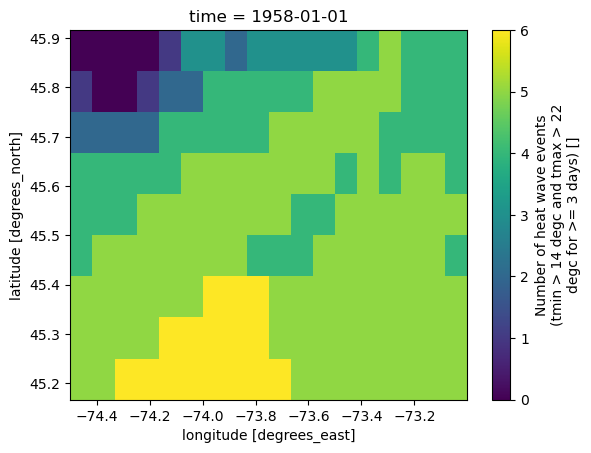

In [23]:
ds.heat_wave_frequency.plot()

### Streaming the data and showing on a map

The results are stored in a folder that is available to thredds, which provides a multiple services to access its datasets. In the case of large outputs, the user could view ths results of the analysis through an OPeNDAP service, so only the data to be shown is downloaded, and not the whole dataset.

#### Get the OPeNDAP url from the 'wpsoutputs'

In [24]:
from urllib.parse import urlparse

output_url = result.get().output
print("output_url = ", output_url)
parsed = urlparse(output_url)
output_path = parsed.path.replace("wpsoutputs", "wps_outputs")
print("output_path = ", output_path)

output_thredds_url = (
    f"https://{parsed.hostname}/twitcher/ows/proxy/thredds/dodsC/birdhouse{output_path}"
)
print("output_thredds_url = ", output_thredds_url)

output_url =  https://pavics.ouranos.ca/wpsoutputs/finch/6a4b85a8-4adf-11f0-bcfb-0242ac13000b/out.nc
output_path =  /wps_outputs/finch/6a4b85a8-4adf-11f0-bcfb-0242ac13000b/out.nc
output_thredds_url =  https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/wps_outputs/finch/6a4b85a8-4adf-11f0-bcfb-0242ac13000b/out.nc


This time, we will be using `hvplot` to build our figure. This tool is a part of the `holoviz` libraries and adds an easy interface to xarray datasets. Since  `geoviews` and `cartopy` are also installed, we can simply pass `geo=True` and a choice for `tiles` to turn the plot into a map. If multiple times were present in the dataset, a slider would appear, letting the user choose the slice. As we are using an OPeNDAP link, only the data that needs to be plotted (the current time slice) is downloaded.

In [25]:
# NBVAL_IGNORE_OUTPUT
import hvplot.xarray

dsremote = xr.open_dataset(output_thredds_url)
dsremote.hvplot.quadmesh(
    "lon",
    "lat",
    "heat_wave_frequency",
    geo=True,
    alpha=0.8,
    frame_height=540,
    cmap="viridis",
    tiles="CartoLight",
)

:DynamicMap   [time]
   :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .QuadMesh.I :QuadMesh   [lon,lat]   (Number of heat wave events (tmin > 14 degc and tmax > 22 degc for >= 3 days))